# TF acs-2 fluorescence

In [156]:
import os
import sys
import tifffile as tiff
import textwrap as tw
import csv
import pandas
import matplotlib
import matplotlib.pyplot as plt

import numpy as np
import itertools as IT
import time


import skimage
from skimage import io as skio
from skimage import color

import glob



sys.path.append("./src")

from utilities import *

In [157]:
## Some adjustments

#matplotlib.use('MacOSX') # For visualising
#matplotlib.use('Agg') # For saving
#matplotlib.use('MacOSX') #TkAgg

#plt.interactive(True)
matplotlib.rcParams.update({'font.size': 12})
np.set_printoptions(precision=3)

In [158]:
os.chdir("/home/pnorv/Dropbox/Projects/Metformin_TF_acs-2/")
odir="."

sourceloc = "/home/pnorv/Dropbox/Projects/Metformin_TF_acs-2/"

In [170]:
## Test images

### Settings

step = 0.001
levels = ["{0:.3f}".format(lvl) for lvl in np.arange(0, 1 + step, step)]


indo = 0.0

sthres=1000
cthres=0.02
size=1000

In [195]:
### Select file


files=glob.glob("./Rep2*/*/arcA wo metf*.tiff")

fl=files[5]


rep,fol,filt=fl.split('/')[1:]
fil=filename(filt)[1]

print fl


./Rep2_24-8-17/arcA wo metf/arcA wo metf12.tiff


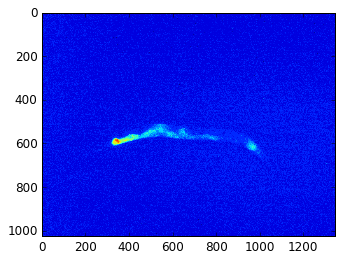

In [196]:
### Load image

image = tiff.imread(fl)

imghsv = color.rgb2hsv(image)
imgrgb = color.hsv2rgb(imghsv)

gray = color.rgb2gray(image)
gray_res=exposure.rescale_intensity(gray)
image_rescale=exposure.rescale_intensity(image)

#Image dimensions
image.shape

# ra = np.array(image[:,:,0])
# ga = np.array(image[:,:,1])
# ba = np.array(image[:,:,2])

# gray = (0.299*ra + 0.587*ga + 0.114*ba)


# Logarithmic



### Label worms


cmap =plt.get_cmap('jet')

image_rgb = cmap(gray_res)
image_rgb = skimage.img_as_ubyte(np.delete(image_rgb, 3, 2))
#image_rgbr=exposure.rescale_intensity(image_rgb)

plt.imshow(image_rgb)

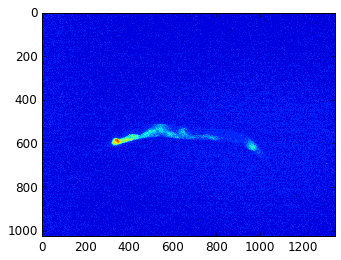

In [197]:
plt.imshow(gray)

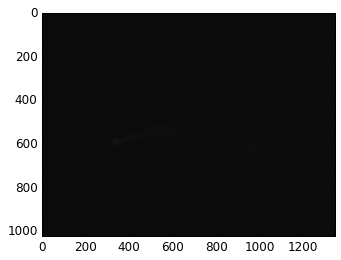

In [198]:
plt.imshow(image)

In [164]:
#Save image
skio.imsave('{}_{}_{}_adjusted_RGB.tiff'.format(rep,fol,fil),image_rgb)

/usr/local/lib/python2.7/dist-packages/skimage/io/_io.py:132: UserWarning: Rep2_24-8-17_arcA wo metf_arcA wo metf9_adjusted_RGB.tiff is a low contrast image
  warn('%s is a low contrast image' % fname)


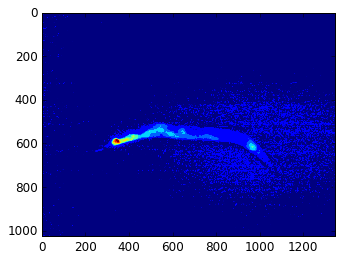

In [199]:
#imghsv, hthres,cthres,size
h = imghsv[:, :, 0]
# s=imghsv[:,:,1]
v = imghsv[:, :, 2]

# Filtering noise
#dh = rank.median(h, disk(3)) / 255.0
dv = rank.median(v, disk(3)) / 255.0
# np.max(dh)
# hmax=np.percentile(h,95)
plt.imshow(dv)

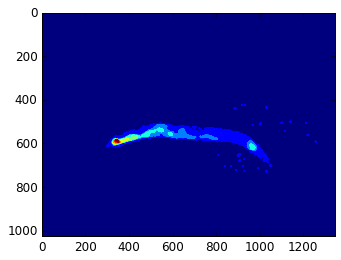

In [200]:
#Expanding 
comb = opening(dv, selem=disk(5))
plt.imshow(comb)

In [ ]:
skio.imsave('{}_{}_{}_adjusted_RGB.tiff'.format(rep,fol,fil),image_rgb)

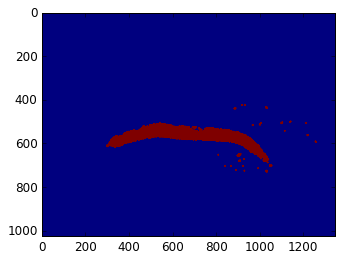

In [215]:
markers = np.zeros_like(comb)
# Mark background
markers[comb == 0] = 1
markers[comb > 0.045] = 2
np.unique(markers)
plt.imshow(markers)

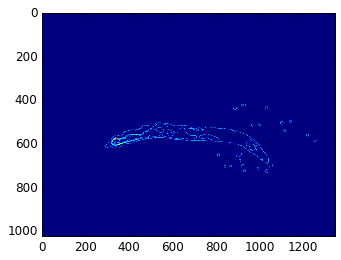

In [222]:
elevation_map = sobel(comb)
plt.imshow(elevation_map )

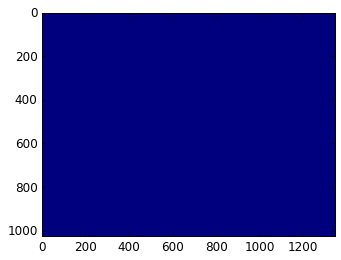

In [223]:
segmentation = watershed(elevation_map, markers)
segmentation = ndi.binary_fill_holes(segmentation - 1)
labeled_worms, _ = ndi.label(segmentation)
plt.imshow(segmentation)

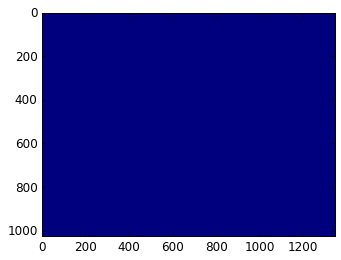

In [224]:
plt.imshow(labeled_worms)

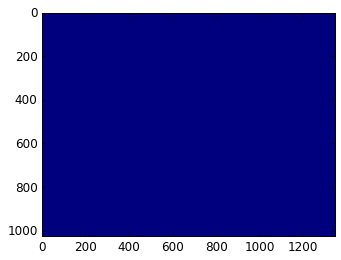

In [204]:
plt.imshow(segmentation)

In [178]:
v1D = np.around(v.ravel(), 3)

In [179]:
v1D

array([0.047, 0.043, 0.047, ..., 0.043, 0.043, 0.043])

In [171]:
for w in list(np.unique(labeled_worms)):
    # print labeled_worms[labeled_worms==w].shape[0]
    if labeled_worms[labeled_worms == w].shape[0] < size:
        labeled_worms[labeled_worms == w] = 0

In [172]:
wormind = list(np.unique(labeled_worms))
worms = {w: labeled_worms[labeled_worms == w].shape[0] for w in wormind}
worms = {wk: wp for wk, wp in worms.items() if wp < 1000000}

In [174]:
#Make white background
extract = imgrgb.copy()
extract[labeled_worms == 0, :] = [1, 1, 1]

contours = measure.find_contours(labeled_worms, 0.8)



In [175]:
contours

[]

In [16]:
h = imghsv[:, :, 0]
v1D = np.around(h.ravel(), 3)
ftable = np.array(freqtable(v1D))
ftable = ftable[np.argsort(ftable[:, 0])]
X, Y, mu, sd = fitgauss(ftable[:, 0], ftable[:, 1])
# What hue threshold o use


#Adjustments depend on the plate
#Hue threshold estimation based on a selection of test images
hthr=mu * 0.995318 + sd * 0.427193 + 0.03


labeled_worms = labeling3(imghsv, hthr,cthres,sthres)


wormind = list(np.unique(labeled_worms))
worms = {w: labeled_worms[labeled_worms == w].shape[0] for w in wormind}
worms = {wk: wp for wk, wp in worms.items() if wp < 1000000}



#Make white background
extract = imgrgb.copy()
extract[labeled_worms == 0, :] = [1, 1, 1]

contours = measure.find_contours(labeled_worms, 0.8)

contours[1][:,1]

TypeError: Improper input: N=2 must not exceed M=0